In [1]:
# Import dependencies
import sys
import os

from copy import deepcopy
import math
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch import nn

myhost = os.uname()[1]
if myhost=='ca1':
    sys.path.insert(0, '/home/dbutts/Code/') 
    data_dir = '/home/dbutts/ColorV1/Data/'  
    work_dir = '/home/dbutts/ColorV1/CLRworkspace/'
#    sys.path.insert(0, '/home/elott1/code/')
#    data_dir = "/home/elott1/data/packaged/"
#    work_dir = '/home/elott1/hartley-models/'
else:
    sys.path.insert(0, '/home/felixbartsch/Code/') 
    datadir = '/Data/FelixData/Conway/'  
    work_dir = '/home/felixbartsch/Data/Colorworkspace/' # Working directory 
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device0 = torch.device('cpu')

print(f'Running on Computer: {myhost}')
print(f'Data directory: {datadir}')
print(f'Working directory: {work_dir}')

%load_ext autoreload
%autoreload 2

# Import NDN tools
import NDNT.utils as utils          # some other utilities\n",
from NDNT.utils import imagesc      # because I'm lazy\n",
from NDNT.utils import ss           # because I'm real lazy\n",
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc
from NDNT.utils.DanUtils import figure_export

from NTdatasets.conway.hartley_datasets import HartleyDataset

Running on Computer: m1
Data directory: /Data/FelixData/Conway/
Working directory: /home/felixbartsch/Data/Colorworkspace/
Invoking __init__.py for NDNT.utils


In [2]:
#data directory structs
fndate = '0727'

#data directory structs
PROOT = 'J22'+fndate
fn = PROOT+'_HC_CC'
#fn = PROOT+'_HC_1D'
fn0 = fn+'_v08'

datadir2 = datadir+'proc/'+PROOT+'/'
analdir = datadir2+'analysis/'
moddir = datadir2+'models/'

In [3]:
# Load dataset

data = HartleyDataset(
    filenames=[fn0],
    datadir=datadir2,
    num_lags=10,
    include_MUs=True,
    drift_interval=16,
    device=device,
    binocular=False,
    eye_config=3
    )

rfs = sio.loadmat(analdir+PROOT+'_LP_GQM_measures.mat')
mod_info = sio.loadmat(datadir2+PROOT+'_LP_stimpos.mat')
valLP = mod_info['valLP'][0]
#valLP = rfs['valLP'][0]

#rfs = sio.loadmat(analdir+PROOT+'_UT_GQM_measures.mat')
#mod_info = sio.loadmat(datadir2+PROOT+'_UT_stimpos.mat')
#valLP = mod_info['valUT'][0]
#rfs['valLP'] = rfs['valUT']

#rfs = sio.loadmat(analdir+PROOT+'_NF_GQM_measures.mat')
#mod_info = sio.loadmat(datadir2+PROOT+'_NF_stimpos.mat')
#valLP = mod_info['valNF'][0]
#rfs['valLP'] = rfs['valNF']

top_corner = [mod_info['top_corner'][0][0],mod_info['top_corner'][1][0]]
#top_corner = [mod_info['top_corner'][0][0],mod_info['top_corner'][0][1]]
NX = mod_info['NX'][0][0]
NCv = len(valLP)

Loading data into memory...
Adjusting stimulus read from disk: mean | std = 0.000 | 0.429
T-range: 0 24240
Extending final block at  24000 24240


In [4]:
NCv

41

In [5]:
#valLP = rfs['valLP'][0]
#NCv = len(valLP)

#rfs['glm_ks'].shape
#NX=52

In [6]:
data.assemble_metadata(time_embed=2, num_lags=10)

  Time embedding...
  Done.


In [7]:
# Init parameters for optimizer

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=1000,
    max_iter=200)

# Init parameters for model

Treg = 0.1
ORIreg = 0.4
SFreg = 0.1
CLRreg = None
PHreg = None
Xregs = [SFreg, ORIreg, PHreg, CLRreg]
xstims = ['OHfreq', 'OHori', 'OHphase', 'OHcolor']
L1reg = 0.0001

In [8]:
if not data.include_MUs:
    lp = list(np.where(data.channel_mapSU < 28)[0])
else:
    lp = list(np.where(data.channel_map < 28)[0])
data.set_cells(lp)
print(data.cells_out)

Output set to 44 cells
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 119, 120, 121, 122, 123, 124, 125, 126, 127, 136, 137, 138, 139, 140, 141, 142, 143, 144, 149]


In [9]:
#array kludge
lp = deepcopy(valLP)
data.set_cells(valLP)
print(data.cells_out)

Output set to 41 cells
[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 119, 120, 121, 122, 123, 124, 125, 126, 136, 137, 138, 139, 140, 141, 142, 143, 144, 149]


In [10]:
lp, valLP

(array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  24,
         25,  26,  27,  28,  30,  32,  33,  34,  35,  36, 119, 120, 121,
        122, 123, 124, 125, 126, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 149]),
 array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  24,
         25,  26,  27,  28,  30,  32,  33,  34,  35,  36, 119, 120, 121,
        122, 123, 124, 125, 126, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 149]))

In [11]:
# Construct meta-stimulus networks

stim_nets = []

for ii in range(4):

    glm_layer = NDNLayer.layer_dict(
        input_dims=[1, data.hartley_dims[ii], 1, data.num_lags],
        num_filters=len(lp),
        bias=False,
        NLtype='lin')
    
    glm_layer['reg_vals'] = {'d2t': Treg, 'd2x': Xregs[ii], 'l1': L1reg}
    
    stim_nets.append(
        FFnetwork.ffnet_dict(
            xstim_n=xstims[ii],
            layer_list=[deepcopy(glm_layer)]
            )
        )

# Construct drift network

glm_drift = NDNLayer.layer_dict(
    input_dims=[1, data.Xdrift.shape[1], 1, 1],
    num_filters=len(lp),
    bias=False,
    NLtype='lin'
    )

glm_drift['reg_vals'] = {'d2x': None}

drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[glm_drift])

# Construct combination network

combD_layer = ChannelLayer.layer_dict(
    num_filters = len(lp),
    NLtype='softplus',
    bias=True)

combD_layer['weights_initializer'] = 'ones'

combD_net = FFnetwork.ffnet_dict(
    xstim_n = None,
    ffnet_n=np.arange(4),
    layer_list = [combD_layer],
    ffnet_type='add')

# Construct null model (just drift)

glm_null_drift = NDNLayer.layer_dict(
    input_dims=[1, data.Xdrift.shape[1], 1, 1],
    num_filters=len(lp),
    bias=False,
    NLtype='softplus'
    )

glm_null_drift['reg_vals'] = {'d2x': None}
null_drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[glm_null_drift])

null_glmD = NDN.NDN( ffnet_list = [null_drift_net], loss_type='poisson')
null_glmD.list_parameters()

# Fit and evaluate null model

null_glmD.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
null_LL = null_glmD.eval_models(data, null_adjusted=False)

Network 0:
  Layer 0:
      weight: torch.Size([7, 41])
Model: M041_N

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 0.864220142364502 sec elapsed


Eval models: 100%|█████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.71it/s]


In [12]:
#x_regs = [0.01,0.03,0.1,0.3,1,3,10,30]
Xreg = 0.2
#for reg in x_regs:

# Construct ori/phase network

glm_layer = NDNLayer.layer_dict(
    input_dims=[data.hartley_dims[2], data.hartley_dims[1], 1, data.num_lags],
    num_filters=len(lp),
    bias=False,
    NLtype='lin')

glm_layer['reg_vals'] = {'d2t': Treg, 'd2x': Xreg, 'l1': L1reg}

stim_nets.append(
    FFnetwork.ffnet_dict(
        xstim_n='OHcov',
        layer_list=[glm_layer]
        )
    )

# Construct model

glmD = NDN.NDN( ffnet_list = [stim_nets[0], stim_nets[3], stim_nets[4], drift_net, combD_net], loss_type='poisson')
glmD.networks[-1].set_parameters(val=False, name='weight')

# Fit and evaluate experimental model
glmD.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
LLd = glmD.eval_models(data, null_adjusted=False)
print(f'Cross-val: {np.mean(null_LL-LLd)}')

Model: M041_N_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.729550838470459 sec elapsed


Eval models: 100%|█████████████████████████████████████████████████████| 25/25 [00:01<00:00, 19.89it/s]

Cross-val: 0.11685050278902054


In [13]:
# Get model weights

glm_weights = []
for i in range(3):
    glm_weights.append(glmD.get_weights(ffnet_target=i))


In [14]:
def display_cells(dataset: HartleyDataset, model_weights, rfs, num_cells=10, L=60, top_corner=None):
    """
    Displays analyses of the first specified number of cells in a HartleyDataset.
    -- model_weights should be in the format [freq_weights, color_weights, ori/phase_weights]
    -- rfs should be sio.loadmat(receptive field weights datafile)
    -- Note: without specified top_corner, entire Hartley will be displayed.
    """
    
    # Constrain valid units to those on the laminar probe
    #lp_units = np.where(dataset.channel_map < 28)[0]
    #if not dataset.include_MUs:
    #    lp_units = lp_units[lp_units<dataset.num_SUs[0]]
    lp_units = dataset.cells_out
    NU = len(lp_units)

    # Get receptive fields
    glm_ks = rfs['glm_ks']
    val_lp = rfs['valLP'].squeeze()
    rf = np.zeros([NU]+list(glm_ks.shape[1:4]))

    # Crop stimuli if necessary
    if top_corner is None:
        opt_hartley = np.zeros([NU, L, L])
    else:
        crop_dim = [int(glm_ks.shape[2]/2), int(glm_ks.shape[3]/2)]
        xcrop = int((top_corner[0]-dataset.stim_location[0,0])/2)
        ycrop = int((top_corner[1]-dataset.stim_location[1,0])/2)
        opt_hartley = np.zeros([NU, crop_dim[0], crop_dim[1]])              # Visual weights for best Hartley stimulus

    # Metadata weights
    k_freq = model_weights[0]                                # Frequency weights (time-embedded)
    k_color = model_weights[1]                               # Color weights (time-embedded)
    k_op = model_weights[2]                                # Orientation/phase weights (time-embedded)
    
    lag_freq = k_freq.var(axis=0).argmax(axis=0)                            # Best frequency lags
    lag_color = k_color.var(axis=0).argmax(axis=0)                          # Best color lags
    
    opt_k_freq =  np.zeros([NU, k_freq.shape[0]])                           # Frequency weights at best lag
    opt_k_color =  np.zeros([NU, k_color.shape[0]])                         # Color weights at best lag
    opt_k_ori = np.zeros([NU, k_op.shape[1]])                               # Orientation weights at best lag, best phase
    opt_k_phase = np.zeros([NU, k_op.shape[0]])                             # Phase weights at best lag, best orientation

    opt_metas = np.zeros([NU, len(data.hartley_dims)], dtype=np.float32)    # Best combined metadatas

    yrange = np.zeros([NU, 2])                                              # Normalized ranges for plotting

    for i in range(NU):

        # Extract best lag for each metadata
        opt_k_freq[i] = k_freq[:,lag_freq[i],i]
        opt_k_color[i] = k_color[:,lag_color[i],i]
        lag_op = k_op[:,:,:,i].reshape(np.product(k_op.shape[:2]), dataset.num_lags).var(axis=0).argmax()
        opt_k_ori[i] = np.max(k_op[:,:,lag_op,i], axis=0)
        opt_k_phase[i] = np.max(k_op[:,:,lag_op,i], axis=1)

        # Get optimal metadata at those lags
        opt_freq = data.hartley_categories[0][opt_k_freq[i].argmax()]
        opt_ori = data.hartley_categories[1][opt_k_ori[i].argmax()]
        opt_phase = data.hartley_categories[2][opt_k_phase[i].argmax()]
        opt_color = data.hartley_categories[3][opt_k_color[i].argmax()]
        opt_metas[i] = [opt_freq, opt_ori, opt_phase, opt_color]

        # Extract best lag of receptive field
        j = np.where(val_lp == lp_units[i])[0]
        if j.size > 0:
            rf_lag = np.var(glm_ks[j[0],:,:,:,:].reshape(np.product(glm_ks.shape[1:4]), glm_ks.shape[4]), axis=0).argmax()
            rf[i] = glm_ks[j[0],:,:,:,rf_lag]

        # Locate ideal Hartley
        match_found, t = False, 0
        while not match_found and t < dataset.NT:
            m = list(data.hartley_metadata[t])
            if m == list(opt_metas[i]):
                match_found = True
                color = int(data.hartley_metadata[t,3])-1
                if top_corner is None:
                    opt_hartley[i] = dataset.stimLP[t,color,:,:]
                else:
                    opt_hartley[i] = dataset.stimLP[t,color,xcrop:xcrop+crop_dim[1],ycrop:ycrop+crop_dim[0]]
            else:
                t += 1
    
        # Normalize tuning curve plots
        opt_k_freq[i] -= opt_k_freq[i].mean()
        range_freq = [opt_k_freq[i].min(),opt_k_freq[i].max()]
        opt_k_color[i] -= opt_k_color[i].mean()
        range_color = [opt_k_color[i].min(),opt_k_color[i].max()]
        opt_k_ori[i] -= opt_k_ori[i].mean()
        range_ori = [opt_k_ori[i].min(),opt_k_ori[i].max()]
        opt_k_phase[i] -= opt_k_phase[i].mean()
        range_phase = [opt_k_phase[i].min(),opt_k_phase[i].max()]
        max_range = [0,0]
        for r in [range_freq,range_color,range_ori,range_phase]:
            max_range[0] = min(max_range[0], r[0])
            max_range[1] = max(max_range[1], r[1])
        yrange[i] = max_range

    # Display cells!
    yrange *= 1.1                               # Buffer to make plots look nicer
    # NC = min(NU, num_cells)
    NC = val_lp.shape[0]
    hartleyfig = ss(NC, 8, row_height=1.75, fighandle=True)
    for i in range(NC):
        cell = val_lp[i]
        j = np.where(dataset.cells_out == cell)[0][0]
        plt.subplot(NC, 8, 8*i+1)                   # Luminance receptive field
        plt.title(f'Cell {cell} Lum. RF')
        imagesc(rf[j][0], max=np.max(np.abs(rf[j])))
        plt.subplot(NC, 8, 8*i+2)                   # L-M receptive field
        plt.title(f'Cell {cell} L-M RF')
        imagesc(rf[j][1], max=np.max(np.abs(rf[j])))
        plt.subplot(NC, 8, 8*i+3)                   # S receptive field
        plt.title(f'Cell {cell} S RF')
        imagesc(rf[j][2], max=np.max(np.abs(rf[j])))
        plt.subplot(NC, 8, 8*i+4)                   # Frequency tuning curve
        plt.title(f'Cell {cell} Sp. Freq.')
        plt.ylim(yrange[j])
        plt.xticks(list(range(8)), [int(i) for i in data.hartley_categories[0]])
        plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
        plt.plot(opt_k_freq[j])
        plt.subplot(NC, 8, 8*i+5)                   # Orientation tuning curve
        plt.title(f'Cell {cell} Orientation')
        plt.ylim(yrange[j])
        plt.xticks([4*i for i in range(3)], [60*i for i in range(3)])
        plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
        plt.plot(opt_k_ori[j])
        plt.subplot(NC, 8, 8*i+6)                   # Phase tuning curve
        plt.title(f'Cell {cell} Phase Shift')
        plt.ylim(yrange[j])
        plt.xticks(list(range(4)), [(i/2/np.pi).round(2) for i in data.hartley_categories[2]])
        plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
        plt.plot(opt_k_phase[j])
        plt.subplot(NC, 8, 8*i+7)                   # Color tuning curve
        plt.title(f'Cell {cell} Color')
        plt.ylim(yrange[j])
        plt.xticks(list(range(3)), [int(i) for i in data.hartley_categories[3]])
        plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
        plt.plot(opt_k_color[j])
        plt.subplot(NC, 8, 8*i+8)                   # Ideal Hartley stimulus
        plt.title(f'Cell {cell} \"Ideal\"')
        imagesc(opt_hartley[j], cmap='Greys')

    plt.show()

    return opt_k_freq, opt_k_ori, opt_k_phase, opt_k_color, hartleyfig

In [15]:
#top_corner=[965,530]

top_corner=None
NX=60

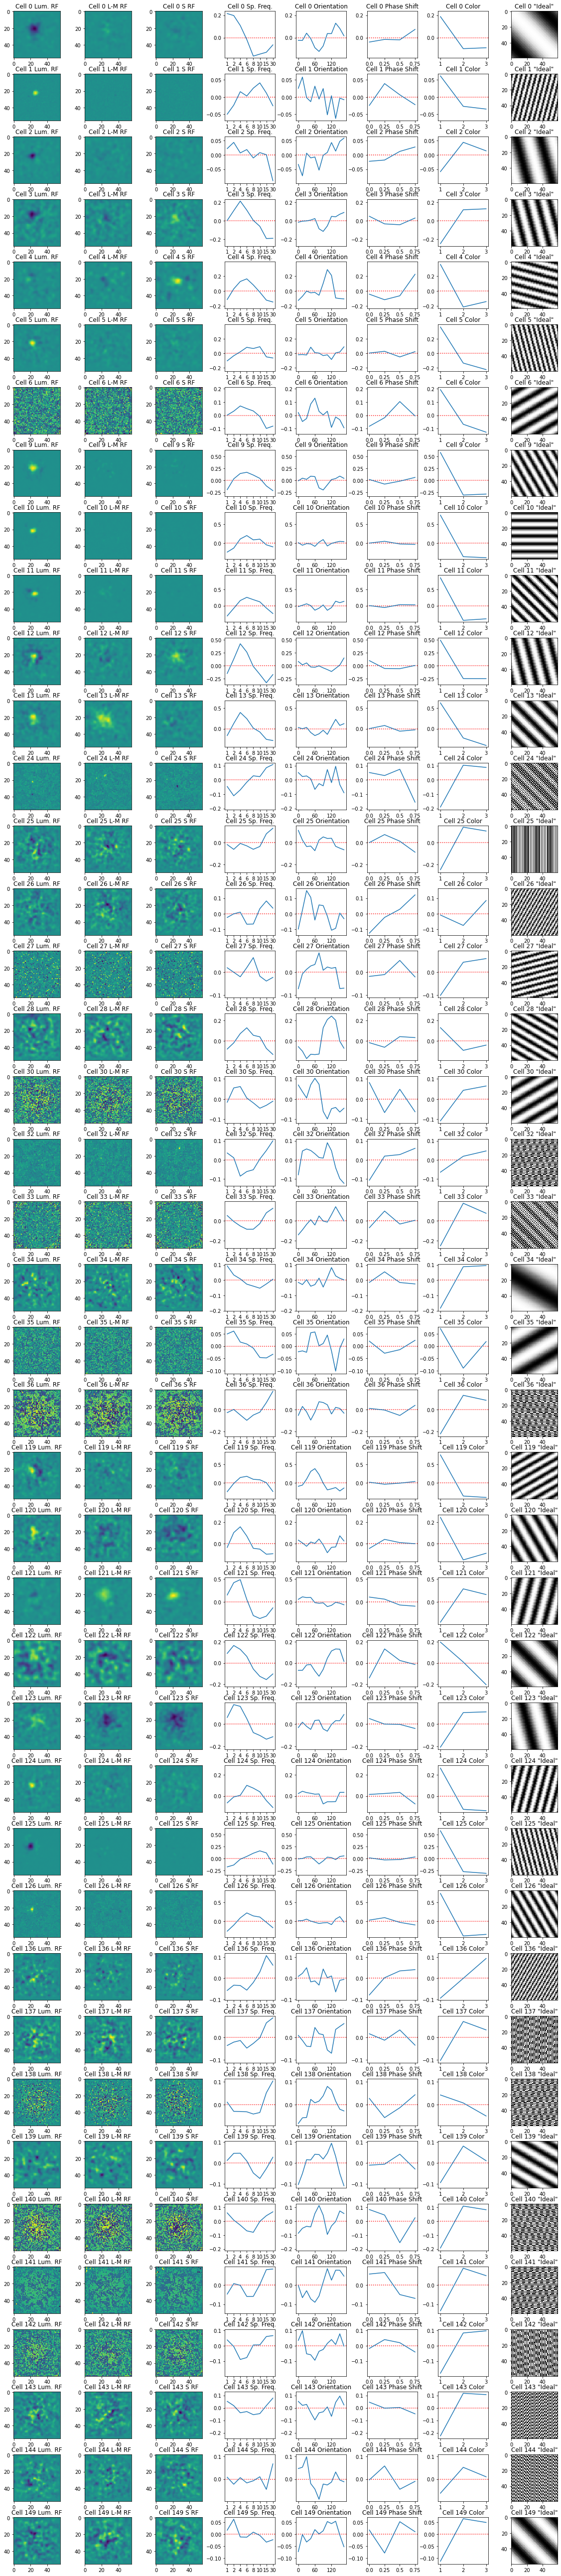

In [16]:
# 220628: 965, 535
# 220722: 980, 530
freq, ori, phase, color, hartleyfig = display_cells(dataset=data, model_weights=glm_weights, rfs=rfs, num_cells=len(lp), 
                                        L=NX, top_corner=top_corner)


In [17]:
sio.savemat(analdir+PROOT+'_LP_HartleyTuning.mat', {
    'freq_k': freq, 'ori_k': ori, 'phase_k': phase, 'color_k': color})

In [18]:
figure_export( hartleyfig, analdir+PROOT+'_LP_HartleyTuning.pdf' )
